# EMAIL CLASSIFICATION

## Objectifs de ce notebook

- Explorer la construction d'un réseau de neurones (Multi Layer Perceptron) ainsi que ses différents types d'architectures
- Appliquer un réseau de nerones pour la classification d'emails (spam ou non spam).

In [1]:
# IMPORTS

# Manipulation et analyse de données sous forme de DataFrame
import pandas as pd

# Calculs numériques et manipulation de tableaux multidimensionnels
import numpy as np

# Visualisation de données
import matplotlib.pyplot as plt

# Division des données en ensemble d'entraînement et de test
from sklearn.model_selection import train_test_split

# Evaluation du modèle
from sklearn.metrics import classification_report, confusion_matrix

# Transformation de textes en matrices TF-IDF (détails plus bas)
from sklearn.feature_extraction.text import TfidfVectorizer

# Transformation des étiquettes en nombres pour la classification
from sklearn.preprocessing import LabelEncoder

# Création et entraînement de modèles de deep learning avec TensorFlow
import tensorflow as tf

# Redimensionner des images
from IPython.display import Image

In [ ]:
# Retirer les quotes pour charger le dataset
# Télécharger en local

"""import kagglehub

path = kagglehub.dataset_download("meruvulikith/190k-spam-ham-email-dataset-for-classification")

print("Path to dataset files:", path)"""

'import kagglehub\n\npath = kagglehub.dataset_download("meruvulikith/190k-spam-ham-email-dataset-for-classification")\n\nprint("Path to dataset files:", path)'

## Etape 1 : Préparation du dataset

### Chargement et premier aperçu du dataset

In [2]:
df = pd.read_csv("spam_Emails_data.csv")
print(df.head())
print()
print(df.describe())
print()
print(df.info())


  label                                               text
0  Spam  viiiiiiagraaaa\nonly for the ones that want to...
1   Ham  got ice thought look az original message ice o...
2  Spam  yo ur wom an ne eds an escapenumber in ch ma n...
3  Spam  start increasing your odds of success & live s...
4   Ham  author jra date escapenumber escapenumber esca...

         label    text
count   193852  193850
unique       2  193848
top        Ham      hi
freq    102160       2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193852 entries, 0 to 193851
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   193852 non-null  object
 1   text    193850 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB
None


Observations : 

- 193 852 lignes
- 2 colonnes : 'label' et 'text'
- 2 valeurs distinctes de 'label' ('Spam' et 'Ham') -> **à prédire**
- 2 entrées de 'text' manquantes

### Il manque le contenu de 2 emails, cela les rend inutiles pour notre dataset => **on les supprime** 

In [3]:
df.dropna(inplace=True)

# Voir pour chaque colonne le nombre d'éléments vides
print(df.isnull().sum())

label    0
text     0
dtype: int64


### Explication : Vectorisation TF-IDF (term frequency - inverse document frequency)

Cette technique permet de transformer des emails (càd du texte) en une représentation numérique, exploitable pour notre MLP.

On crée un vectoriseur qui va convertir du texte en une matrice de nombres, en fonction de l'importance des mots.

    => Plus un mot est important, plus son score sera élevé.

Pour chaque mot w dans un document d, le TF-IDF est calculé ainsi : 

- TF(w) = (Nombre de fois où w apparaît dans d) / (Nombre total de mots dans d)

- IDF(w) = log (Nombre total de documents / Nombre de documents qui contiennent w)

`TF-IDF(w) = TF(w) * IDF(w)`

En d'autres termes, pour qu'un mot soit considéré comme important : 

- Il doit apparaître suffisamment souvent dans un document. (TF élevé)

- Il doit être présent dans un peu moins de documents que les autres. (IDF élevé)

Ainsi les mots très courants (ex. "le", "et", "de") ont un score faible car ils apparaissent dans presque tous les documents.

In [4]:
# Tokenisation et vectorisation
vectorizer = TfidfVectorizer(max_features=5000)  # Convertir texte en features
X = vectorizer.fit_transform(df['text']).toarray()

### Encodage des labels

Plus simple que le TF-IDF, on associe chaque label à un nombre

In [5]:
encoder = LabelEncoder()
y = encoder.fit_transform(df['label'])  # spam = 1, ham = 0

### Division du dataset

Pour entraîner notre modèle, nous divisons le dataset en 2 ensembles.
- Ensemble d'entraînement
- Ensemble de test

**Quel intérêt ?** 

Cette séparation nous permet de tester le modèle sur des données qu'il n'a pas vu lors de l'entraînement.

On vérifie sa capacité de généralisation et on évite le surapprentissage (overfitting).

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Etape 2 : Construction et entrainement du réseau de neurones

### Explication : structure du MLP (Multi Layer Perceptron)

Le modèle suit une architecture séquentielle, où les couches sont empilées les unes après les autres : 
- **1ère couche *dense*** (128 neurones). `input_shape=(X_train.shape[1],)` => la couche attend en entrée un vecteur de taille égale au nombres de features dans le dataset d'entrainement.
    
    `activation ReLU (Rectified Linear Unit) : ReLU(x) = max(0, x)`

    Pourquoi ? aide à éviter la disparition de gradient (cf descente de gradient) et accélère l'entrainement.

- **2ème couche *dropout*** : 30% des neurones sont désactivés aléatoirement à chaque itération d'entrainement.

    Pourquoi ? évite l'overfitting (quand le modèle apprend trop facilement à l'entrainement des données) et améliore la généralisation des prédictions.

- **3ème couche *dense*** (64 neurones).

    Pourquoi une autre couche cachée ? apprendre des relations plus profondes entre les mots. capturer des motifs plus abstrait.

- **4ème couche *dense*** (1 neurone). Donne la probabilité que le mail soit un spam.

    `activation sigmoid : sigmoid(x) = 1 / (1 + exp(-x))`

    Pourquoi sigmoïde ? donne en sortie une probabilité entre 0 et 1 : si sortie > 0.5 => spam, sinon non spam

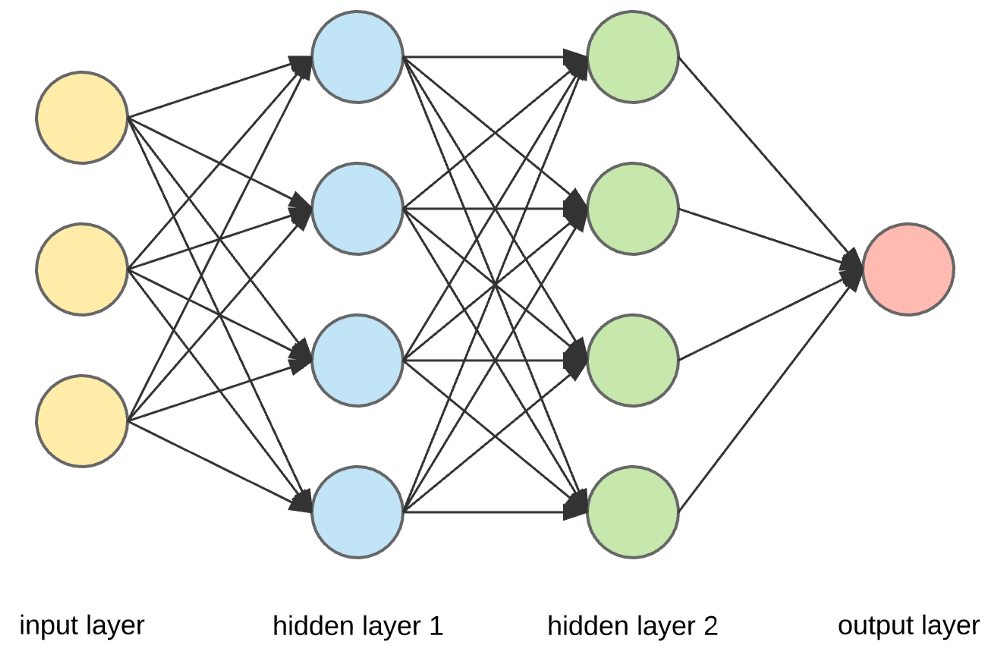

In [13]:
Image("./images/neural_network.png", width=800)

In [7]:
# Création du modèle MLP
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Configuration du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


c:\Users\abdal\anaconda3\envs\titanic_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4847/4847 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9595 - loss: 0.1200 - val_accuracy: 0.9802 - val_loss: 0.0565
Epoch 2/10
4847/4847 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9877 - loss: 0.0373 - val_accuracy: 0.9840 - val_loss: 0.0519
Epoch 3/10
4847/4847 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9940 - loss: 0.0200 - val_accuracy: 0.9868 - val_loss: 0.0515
Epoch 4/10
4847/4847 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9963 - loss: 0.0127 - val_accuracy: 0.9877 - val_loss: 0.0507
Epoch 5/10
4847/4847 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9971 - loss: 0.0092 - val_accuracy: 0.9882 - val_loss: 0.0594
Epoch 6/10
4847/4847 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9976 - loss: 0.0076 - val_accuracy: 0.9882 - val_loss: 0.0589
Epoch 7/10
4847/4847 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9978 - loss: 0.0069 - val_accuracy: 0.9882 - val_loss: 0.0656
Epoch 8/10
4847/4847 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9983 - loss: 0

### Comprendre les métriques de l'apprentissage

- `Epoch` : époque d'apprentissage, càd un passage complet sur le dataset d'entrainement
- `x ms/step` : temps moyen pour traiter un batch, càd un morceau de dataset
- `accuracy` : précision obtenue sur les données d'entrainement
- `loss` : perte obtenue sur les données d'entrainement
- `val_accuracy` : précision obtenue sur les données de validation
- `val_loss` : perte obtenue sur les données de validation

**Note** : l'ensemble de validation est une partie du dataset d'entrainement, utilisé pour évaluer la performance du modèle **pendant l'apprentissage.**

Il aide à détecter le surapprentissage. Si `val_accuracy` est beaucoup plus faible que `accuracy` (ou si `val_loss` est beaucoup plus élevé que `loss`), c'est que le modèle mémorise trop et ne généralise pas assez.

**Attention** : L’ensemble de validation est différent de l’ensemble de test, qui est utilisé uniquement **après l’entraînement** final pour évaluer la vraie performance du modèle.

### Explication : descente de gradient

La descente de gradient est un algorithme d’optimisation utilisé pour **ajuster les paramètres** d’un modèle de machine learning (comme les poids d’un réseau de neurones) afin de réduire l’erreur entre ses prédictions et les valeurs réelles.

De manière générale, une descente de gradient sert à trouver le **minimum d'une fonction**

Il s'agit de minimiser une fonction de coût `J(Xn)`, fonction qui mesure l'erreur entre les prédictions et les vraies valeurs.

* `Xn` étant un poids du réseau de neurones

La descente de gradient fonctionne comme une marche dans une vallée :
- Imaginons que la fonction de coût est une montagne et que nous voulons descendre jusqu’au point le plus bas (le minimum global).
- À chaque étape, nous regardons la pente et descendons dans la direction la plus abrupte pour atteindre le fond le plus rapidement possible.
- Cette pente est donnée par le gradient (la dérivée de la fonction de coût).

Itération d'une descente de gradient : `Xn+1 = Xn - α * f'(Xn)`

avec : 
- `Xn` le point initial
- `Xn+1` le point suivant dans l'algo de descente
- `α` le taux d'apprentisage (learning rate) 
- `f'(Xn)` la dérivée (càd la pente) de la fonction de coût au point Xn

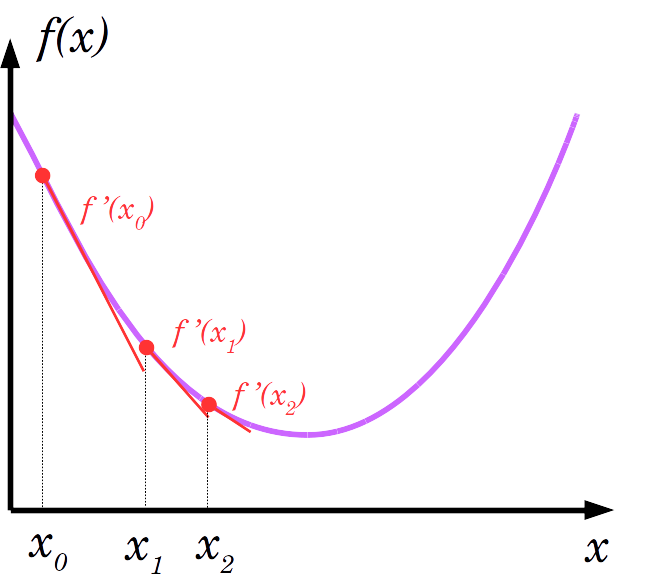

In [14]:
Image("./images/gradient-descent.png", width=800)

Le taux d'apprentisage `α`, c'est la taille des *pas* effectués pour atteindre le minimum de la fonction de coût (le fond de la vallée).

Le choix de `α` dépend du comportement de la fonction de coût :
- Si `𝛼` est trop grand, on risque d’osciller et de ne jamais atteindre le minimum.
- Si `𝛼` est trop petit, l’apprentissage sera (trop) lent.

Il faut en tester plusieurs et prendre le meilleur.

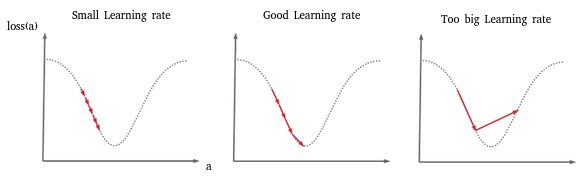

In [15]:
Image("./images/learning_rate.jpg", width=800)

#### Problèmes classiques de la descente de gradient

1. #### Minima locaux

Il y'a plusieurs minima locaux (des creux)

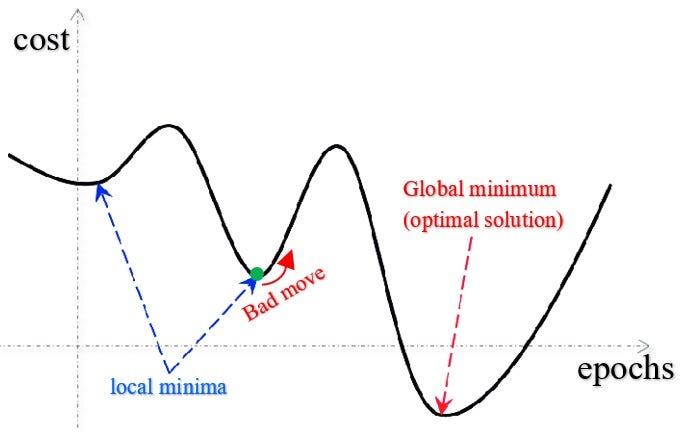

: 

In [ ]:
Image("./images/minima.jpg", width=700)


Ainsi le point de convergence va beaucoup dépendre du point initial (initié aléatoirement).

Parfois l'algo trouve bien le minimum global, d'autres fois il convergence sur un minimum local.

**Solution ? faire tourner l'algo plusieurs fois et garder le plus petit des minima.**

2. #### Disparition de gradient

Lorsque le gradient est trop petit.

Le gradient diminue au fil de la rétropropagation, faisant que les couches antérieures du réseau de neurones apprennent plus lentement que les autres.

**Solution ? utiliser une fonction d'activation lors de l'apprentissage (comme ReLU)**

3. #### Explosion de gradient

Quand le gradient est trop grand => crée un modèle instable.

**Solution ? réduire la dimensionnalité des données peut aider dans ce cas**

## Etape 3 : Evaluation du modèle

### Utilisation de l'ensemble de test

On évalue la précision du modèle sur notre ensemble de test. Il n'a pas servi à l'entrainement, donc le modèle ne l'a jamais vu.

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Précision sur les données de test: {test_acc * 100:.2f}%')

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9897 - loss: 0.0811
Précision sur les données de test: 98.87%


**Comprendre les résultats** : 
- test_loss : La perte (loss), quantifie l'erreur entre les prédictions du modèle et les vraies valeurs.
- test_acc : La précision (accuracy), représente le pourcentage de prédictions correctes.

### Visualiser l'évolution de la perte (loss) et de la précision (accuracy) au cours de l'entrainement

**Quel intérêt ?**

Observer comment le modèle progresse et identifier d'éventuels problème d'apprentissage.

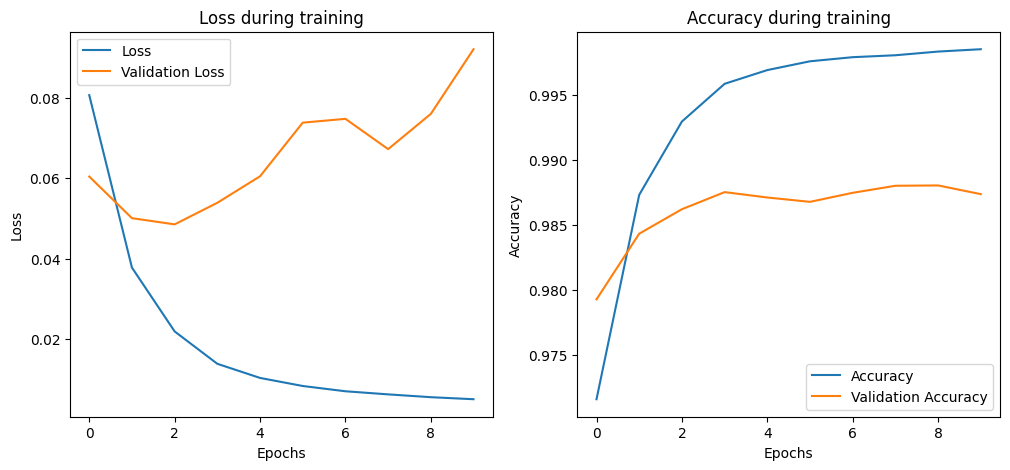

In [15]:
#  Tracé de la perte et de la précision
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss during training')
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy during training')
    
    plt.show()

plot_training_history(history)

**Observation :** 
- Les pertes d'entrainement et de validation sont déjà faibles au début. Celle d'entrainement diminue tandis que celle de validation augmente un peu.
- Les précisions d'entrainement et de validation sont déjà élevées au début. Celle de validation augmente moins que celle d'entrainement.

**Cela laisse suggérer un léger surapprentissage.**

### Explication : Matrice de confusion et rapport de classification

1. **Matrice de confusion**

Dans le cadre d'une classification binaire (Spam/Ham), une matrice de confusion permet de visualiser les erreurs de classification : 

[[TN  FP]

 [FN  TP]]

- TN : True Negative (emails non-spam classifiés correctement)
- FP : False Positive (emails spam classifiés comme non-spam)
- FN : False Negative (emails non-spam classifiés comme spam)
- TP : True Positive (emails spam classifiés correctement)

2. **Rapport de classification**

Permet d'obtenir un rapport détaillé des performance du modèle : 
- Précision (Precision) : Proportion de vrais positifs parmi toutes les prédictions positives.
- Rappel (Recall) : Proportion de vrais positifs détectés parmi les réels positifs.
- F1-score : Moyenne harmonique entre précision et rappel.
- Support : Nombre d’échantillons par classe.

In [17]:
# show what texts were been wrongfully classified
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")

print(classification_report(y_test, y_pred))

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step
Confusion Matrix:
[[20077   240]
 [  249 18204]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20317
           1       0.99      0.99      0.99     18453

    accuracy                           0.99     38770
   macro avg       0.99      0.99      0.99     38770
weighted avg       0.99      0.99      0.99     38770



### Afficher les emails mal classifiés

**Quel intérêt ?**

- Permet d'analyser les erreurs du modèle.
- Aide à comprendre quels types d'emails sont mal classifiés.
- Peut être utilisé pour améliorer le modèle (ajouter plus de données, ajuster le seuil, améliorer les features, etc.).

In [18]:
#  Identification des emails mal classifiés
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
misclassified_indices = np.where(y_pred != y_test)[0]
misclassified_emails = df.iloc[misclassified_indices]
print("Mails mal classifiés:")
print(misclassified_emails[['text', 'label']])

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step
Mails mal classifiés:
                                                    text label
55     they are apparently not going to roll over .\n...   Ham
263    lncrease your cum vescapenumberlume and orgasm...  Spam
277    on jun escapenumber escapenumber escapenumber ...   Ham
506    mr edward lugard bills exchange department iri...  Spam
528    get canm . ob first thing monday , this is goi...  Spam
...                                                  ...   ...
38214  if anyone has seen our dog meesha please call ...   Ham
38236  want to be the top all night long be sexual gi...  Spam
38514  in the wake of us and british military action ...   Ham
38606  this is the postfix program at host mx 2 . oi ...  Spam
38721  another option is to use ntldr the windows nt ...   Ham

[489 rows x 2 columns]
